In [1]:
# Generate simulation data

In [2]:
import sys
sys.path.append("./mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
import numpy as np
import numpy.random as npr
from data_gen import MyDataGen
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tqdm import tqdm


from cp_predict import CPNaive, CPSimple, CPSimple1

In [23]:
xysize = (10, 2)
A = npr.randn(*xysize).T;
ntrain = 100;
ntest = 10000;
noise_std = 1
model_type = "MLP"
verbose = 2
alpha = 0.2

0.2

In [24]:
def _get_model(typ="SVR"):
    if typ == "SVR":
        return MultiOutputRegressor(SVR(kernel="rbf"))
    elif typ == "MLP":
        return MultiOutputRegressor(MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000))
    elif typ == "LIN":
        return MultiOutputRegressor(LinearRegression())


def _gen_data(ntrain, seed):
    A = npr.randn(*xysize).T;
    datagen = MyDataGen(xysize=xysize, A=A);
    np.random.seed(seed)
    seeds = npr.randint(0, 1000000, 2)    
    Xtrain, Ytrain = datagen(n=ntrain, noise_std=noise_std, seed=seeds[0]);
    Xtest, Ytest = datagen(n=10000, noise_std=noise_std, seed=seeds[1]);
    return Xtrain, Ytrain, Xtest, Ytest, A

In [25]:
def _get_gs(X, A, noise_std):
    return (X @ A.T)**2 +  noise_std**2
def _get_fs(X, A):
    return X @ A.T
X, Y, Xt, Yt, A = _gen_data(ntrain, 0);
fs, gs = _get_fs(X, A), _get_gs(X, A, noise_std)
fts, gts = _get_fs(Xt, A), _get_gs(Xt, A, noise_std);


In [47]:
cpfit = CPSimple1(Y, fs, gs);

In [50]:
cpfit.fit(0.2, h=1, opt_params={"bds": [1e-4, 1000]})

In [46]:
cpfit.fit_root(0.2, h=10, opt_params={"bds": [1e-4, 1000]})
cpfit.eps

2024-07-25 17:15:52,783 - cp_predict.cp_simple - WARNING -  cp_simple.py:203 - bds[0] is adjusted to 0.0004.


1.781761108391048

In [37]:
np.logspace(-4.1, 3, 10)

array([7.94328235e-05, 4.88527357e-04, 3.00453853e-03, 1.84784980e-02,
       1.13646367e-01, 6.98947321e-01, 4.29866235e+00, 2.64376119e+01,
       1.62596469e+02, 1.00000000e+03])

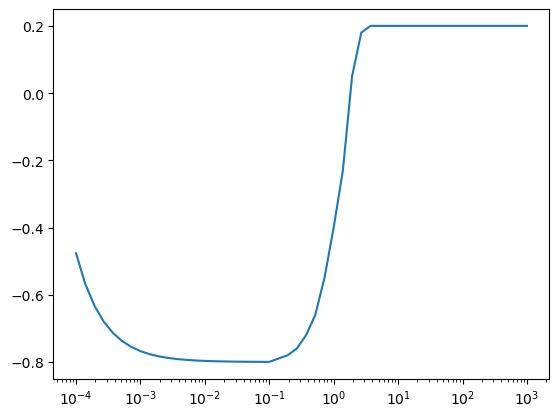

In [27]:
epss = np.logspace(-4, 3, 50)
vs = []
for eps in epss: 
    v = cpfit._phi_fn(eps, alpha=alpha, h=100).mean()
    vs.append(v)

plt.plot(epss, vs)
plt.xscale("log")

In [19]:
vs

[-0.743268528144652,
 -0.7591711307333594,
 -0.7706160059805884,
 -0.7788527187262685,
 -0.7847805628833091,
 -0.7890467473967884,
 -0.7921170592721213,
 -0.7943267187440592,
 -0.7959169790132482,
 -0.7970614665523067,
 -0.7978851378467954,
 -0.7984779222901802,
 -0.7989045407799927,
 -0.7992115720209779,
 -0.7994325380424525,
 -0.7995915641726034,
 -0.7997060130699862,
 -0.7987883803988671,
 -0.7978476591204522,
 -0.7958903213549292,
 -0.7919210250151789,
 -0.7869431223632778,
 -0.7819590260146512,
 -0.77097047235074,
 -0.7499787111000867,
 -0.7279846417868757,
 -0.6839889119451271,
 -0.593991987822576,
 -0.4239942052948029,
 -0.18299580654859185,
 0.050003033465389035,
 0.17200218794653704,
 0.20000156452565182,
 0.20000109567084956,
 0.2000007328288316,
 0.20000044492533456,
 0.20000022161794698,
 0.20000007418527485,
 0.20000001128944034,
 0.2000000003644001,
 0.2000000000005666,
 0.2,
 0.20000000000000004,
 0.20000000000000004,
 0.20000000000000004,
 0.20000000000000004,
 0.200000

In [16]:
hs = np.logspace(-5, 3, 50)
epss = []
covprobs = []
for h in tqdm(hs):
    cpfit.fit(alpha=alpha, h=h, opt_params={"bds": (0.01, 1000)})
    Rs_test, in_sets = cpfit.predict(fts, Yt)
    epss.append(cpfit.eps)
    covprobs.append(in_sets.mean())

  0%|                                                                                     | 0/50 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 148.28it/s]


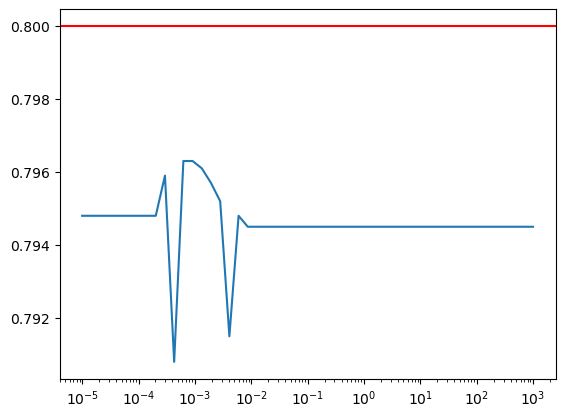

In [17]:
plt.plot(hs, covprobs)
plt.axhline(y=1-alpha, color="red")
plt.xscale("log")

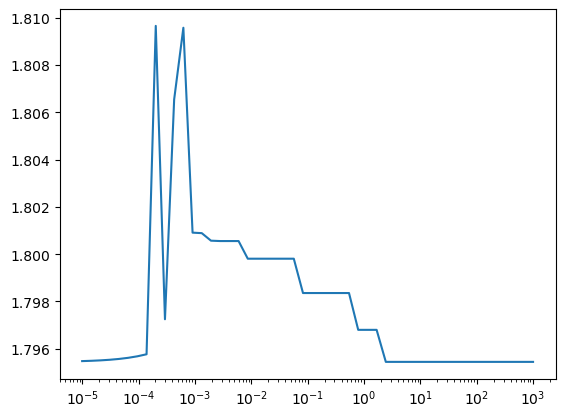

In [88]:
plt.plot(hs, epss)
plt.xscale("log")